In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv2DTranspose, concatenate, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence, to_categorical
from sklearn.model_selection import train_test_split

In [2]:
# Paths (replace with your actual paths)
train_path = 'C:/Users/YELLEPEDDI KRISHNA/Desktop/YsskA/Train'
test_path = 'C:/Users/YELLEPEDDI KRISHNA/Desktop/YsskA/Test'
val_path = 'C:/Users/YELLEPEDDI KRISHNA/Desktop/YsskA/Validation'

In [3]:
# Step 1: Generate Masked Images
def generate_masks(image_dir, mask_dir):
    os.makedirs(mask_dir, exist_ok=True)
    for subfolder in ['Asthma', 'Pnuemothorax', 'Covid-19', 'Non-Covid-19']:
        sub_img_dir = os.path.join(image_dir, subfolder)
        sub_mask_dir = os.path.join(mask_dir, subfolder)
        os.makedirs(sub_mask_dir, exist_ok=True)
        for filename in os.listdir(sub_img_dir):
            img_path = os.path.join(sub_img_dir, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            _, mask = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
            mask_path = os.path.join(sub_mask_dir, filename)
            cv2.imwrite(mask_path, mask)

generate_masks(train_path, train_path + '_Mask')
generate_masks(test_path, test_path + '_Mask')
generate_masks(val_path, val_path + '_Mask')

In [4]:
class SegmentationDataGenerator(Sequence):
    def __init__(self, image_dir, mask_dir, batch_size=32
                 , target_size=(256, 256), num_classes=4):
        self.image_datagen = ImageDataGenerator(rescale=1./255)
        self.mask_datagen = ImageDataGenerator(rescale=1./255)
        self.image_generator = self.image_datagen.flow_from_directory(image_dir, target_size=target_size, batch_size=batch_size, class_mode=None)
        self.mask_generator = self.mask_datagen.flow_from_directory(mask_dir, target_size=target_size, batch_size=batch_size, class_mode=None, color_mode='grayscale')
        self.batch_size = batch_size
        self.target_size = target_size
        self.num_classes = num_classes

    def __len__(self):
        return len(self.image_generator)

    def __getitem__(self, index):
        images = self.image_generator[index]
        masks = self.mask_generator[index]
        
        # Resize masks to match output shape (256, 256)
        masks = tf.image.resize(masks, (256, 256))  # Resize masks to (256, 256)
        masks = np.squeeze(masks, axis=-1)  # Remove the last dimension (256, 256, 1) -> (128, 128)
        masks = to_categorical(masks, num_classes=self.num_classes)  # One-hot encode (128, 128, num_classes)
        
        return images, masks


In [5]:
# Step 2: Panoptic Segmentation using U-Net
def build_unet(input_shape=(256, 256, 4), num_classes=4):
    inputs = tf.keras.Input(shape=input_shape)
    
    # Load EfficientNetB4 as the backbone
    base_model = EfficientNetB4(include_top=False, weights='imagenet', input_tensor=inputs)
    
    # Use feature maps from EfficientNetB4
    encoder_outputs = [
        base_model.get_layer('block2a_expand_activation').output,  # Example layer, adjust as needed
        base_model.get_layer('block3a_expand_activation').output,  # Example layer, adjust as needed
        base_model.get_layer('block4a_expand_activation').output,  # Example layer, adjust as needed
        base_model.get_layer('block6a_expand_activation').output,  # Example layer, adjust as needed
    ]
    
    # Decoder
    x = encoder_outputs[-1]
    for i in range(len(encoder_outputs) - 1, 0, -1):
        x = Conv2DTranspose(512 // (2 ** i), (3, 3), strides=(2, 2), padding='same')(x)
        x = concatenate([x, encoder_outputs[i - 1]])
        x = Conv2D(512 // (2 ** i), (3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
    
    # Final output layer for segmentation
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(x)  # Output shape: (256, 256, num_classes)
    
    model = Model(inputs, outputs)
    return model

# Custom Data Generator for Segmentation
class SegmentationDataGenerator(Sequence):
    def __init__(self, image_dir, mask_dir, batch_size=16, target_size=(256, 256), num_classes=4):
        self.image_datagen = ImageDataGenerator(rescale=1./255)
        self.mask_datagen = ImageDataGenerator(rescale=1./255)
        self.image_generator = self.image_datagen.flow_from_directory(image_dir, target_size=target_size, batch_size=batch_size, class_mode=None)
        self.mask_generator = self.mask_datagen.flow_from_directory(mask_dir, target_size=target_size, batch_size=batch_size, class_mode=None, color_mode='grayscale')
        self.batch_size = batch_size
        self.target_size = target_size
        self.num_classes = num_classes

    def __len__(self):
        return len(self.image_generator)

    def __getitem__(self, index):
        images = self.image_generator[index]
        masks = self.mask_generator[index]
        
        # Convert grayscale masks to one-hot encoded masks
        masks = np.squeeze(masks, axis=-1)  # Remove the last dimension (256, 256, 1) -> (256, 256)
        masks = to_categorical(masks, num_classes=self.num_classes)  # One-hot encode (256, 256, num_classes)
        
        return images, masks



In [6]:
# Build and compile the U-Net model
unet_model = build_unet(input_shape=(256, 256, 3), num_classes=4)
unet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Create data generators
train_gen = SegmentationDataGenerator(train_path, train_path + '_Mask', num_classes=4)
val_gen = SegmentationDataGenerator(val_path, val_path + '_Mask', num_classes=4)



Found 760 images belonging to 4 classes.
Found 760 images belonging to 4 classes.
Found 800 images belonging to 4 classes.
Found 800 images belonging to 4 classes.


In [7]:
def build_unet(input_shape=(256, 256, 3), num_classes=4):
    inputs = tf.keras.Input(shape=input_shape)
    
    # Load EfficientNetB4 as the backbone
    base_model = EfficientNetB4(include_top=False, weights='imagenet', input_tensor=inputs)
    
    # Use feature maps from EfficientNetB4
    encoder_outputs = [
        base_model.get_layer('block2a_expand_activation').output,
        base_model.get_layer('block3a_expand_activation').output,
        base_model.get_layer('block4a_expand_activation').output,
        base_model.get_layer('block6a_expand_activation').output,
    ]
    
    # Decoder (Upsample to match target size)
    x = encoder_outputs[-1]
    for i in range(len(encoder_outputs) - 1, 0, -1):
        x = Conv2DTranspose(512 // (2 ** i), (3, 3), strides=(2, 2), padding='same')(x)
        x = concatenate([x, encoder_outputs[i - 1]])
        x = Conv2D(512 // (2 ** i), (3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
    
    # Final upsampling to (256, 256) to match target size
    x = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(x)  # Upsample to (256, 256)
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(x)  # Output shape: (256, 256, num_classes)
    
    model = Model(inputs, outputs)
    return model


In [8]:
class SegmentationDataGenerator(Sequence):
    def __init__(self, image_dir, mask_dir, batch_size=16, target_size=(256, 256), num_classes=4):
        self.image_datagen = ImageDataGenerator(rescale=1./255)
        self.mask_datagen = ImageDataGenerator(rescale=1./255)
        self.image_generator = self.image_datagen.flow_from_directory(image_dir, target_size=target_size, batch_size=batch_size, class_mode=None)
        self.mask_generator = self.mask_datagen.flow_from_directory(mask_dir, target_size=target_size, batch_size=batch_size, class_mode=None, color_mode='grayscale')
        self.batch_size = batch_size
        self.target_size = target_size
        self.num_classes = num_classes

    def __len__(self):
        return len(self.image_generator)

    def __getitem__(self, index):
        images = self.image_generator[index]
        masks = self.mask_generator[index]
        
        # Resize masks to match output shape
        masks = tf.image.resize(masks, (256, 256))  # Resize masks to (256, 256)
        masks = np.squeeze(masks, axis=-1)  # Remove the last dimension (256, 256, 1) -> (256, 256)
        masks = to_categorical(masks, num_classes=self.num_classes)  # One-hot encode (256, 256, num_classes)
        
        return images, masks


In [9]:
# Build and compile the U-Net model
unet_model = build_unet(input_shape=(256, 256, 3), num_classes=4)
unet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Create data generators
train_gen = SegmentationDataGenerator(train_path, train_path + '_Mask', num_classes=4)
val_gen = SegmentationDataGenerator(val_path, val_path + '_Mask', num_classes=4)

# Train Segmentation Model
history = unet_model.fit(train_gen, validation_data=val_gen, epochs=10)


Found 760 images belonging to 4 classes.
Found 760 images belonging to 4 classes.
Found 800 images belonging to 4 classes.
Found 800 images belonging to 4 classes.
Epoch 1/10


d:\Python 3.11.4\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


48/48 ━━━━━━━━━━━━━━━━━━━━ 2163s 44s/step - accuracy: 0.6878 - loss: 0.7017 - val_accuracy: 0.6286 - val_loss: 1.8273
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 2080s 43s/step - accuracy: 0.7925 - loss: 0.4605 - val_accuracy: 0.6605 - val_loss: 0.8814
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 2202s 46s/step - accuracy: 0.8028 - loss: 0.4430 - val_accuracy: 0.6556 - val_loss: 1.0200
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 2165s 45s/step - accuracy: 0.8144 - loss: 0.4170 - val_accuracy: 0.6551 - val_loss: 0.7726
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 2140s 45s/step - accuracy: 0.8287 - loss: 0.3876 - val_accuracy: 0.7010 - val_loss: 0.6729
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 2147s 45s/step - accuracy: 0.8392 - loss: 0.3647 - val_accuracy: 0.6904 - val_loss: 0.7168
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 2359s 49s/step - accuracy: 0.8519 - loss: 0.3359 - val_accuracy: 0.7207 - val_loss: 0.6665
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 2596s 53s/step - accuracy: 0.8641 - loss: 0.3138 - val_accuracy: 0.719

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


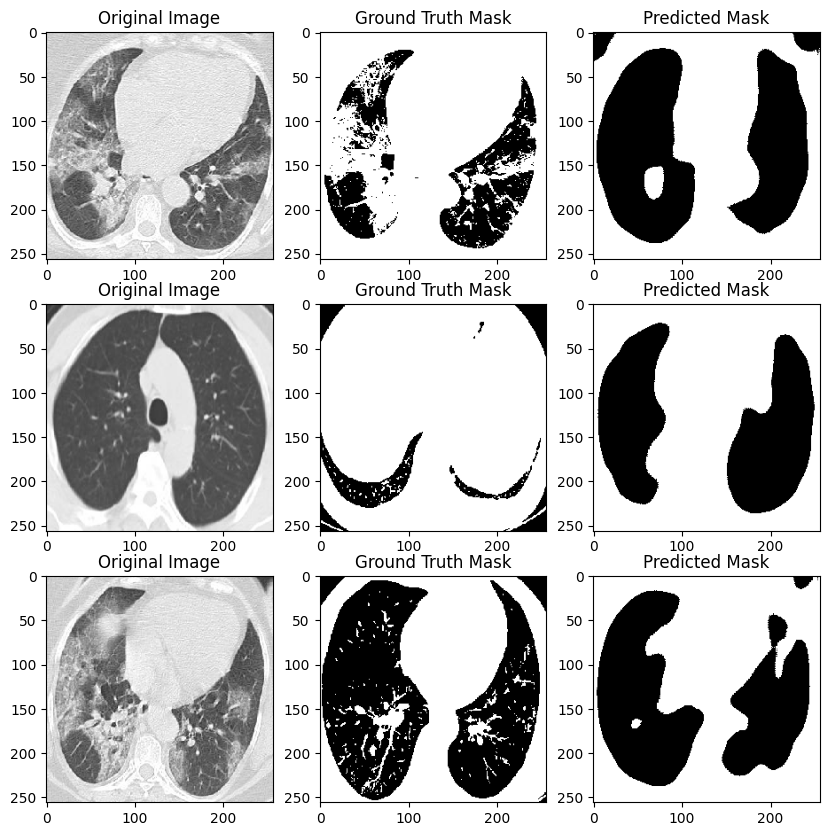

In [10]:
import matplotlib.pyplot as plt
# Visualize Segmentation Output
def visualize_predictions(model, generator):
    images, masks = generator[0]
    predictions = model.predict(images)
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    for i in range(3):
        axes[i, 0].imshow(images[i])
        axes[i, 0].set_title("Original Image")
        axes[i, 1].imshow(np.argmax(masks[i], axis=-1), cmap='gray')
        axes[i, 1].set_title("Ground Truth Mask")
        axes[i, 2].imshow(np.argmax(predictions[i], axis=-1), cmap='gray')
        axes[i, 2].set_title("Predicted Mask")
    plt.show()

visualize_predictions(unet_model, val_gen)

In [11]:
# Visualization Callback
from tensorflow.keras.callbacks import Callback
class VisualizationCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Randomly select an image for visualization
        image_files = os.listdir(train_path)
        random_image = random.choice(image_files)
        
        img_path = os.path.join(train_path, random_image)
        img = image.load_img(img_path, target_size=(256, 256))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)

        mask_file = random_image.replace('.jpg', '_Mask.png')
        mask_path = os.path.join(train_path + '_Mask', mask_file)
        true_mask = image.load_img(mask_path, target_size=(256, 256), color_mode='grayscale')
        true_mask_array = image.img_to_array(true_mask)
        true_mask_array = np.squeeze(true_mask_array, axis=-1)

        # Predict the segmentation mask
        pred_mask = unet_model.predict(img_array)
        pred_mask = np.argmax(pred_mask, axis=-1)
        

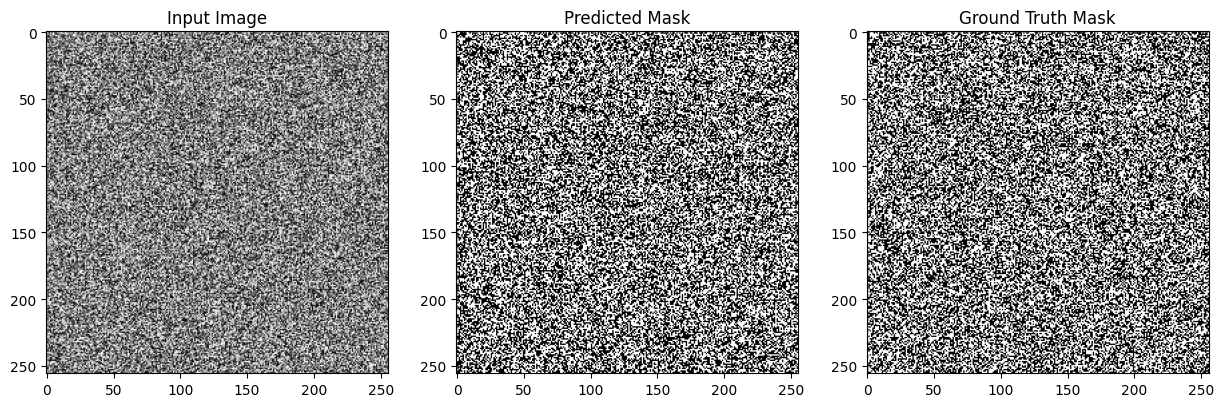

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Example dummy image and mask data
img_array = np.random.rand(256, 256)  # Simulating a grayscale image
pred_mask = np.random.randint(0, 2, (256, 256))  # Simulating a binary mask
true_mask_array = np.random.randint(0, 2, (256, 256))  # Simulating a ground truth mask

def visualize(image, pred_mask, true_mask=None):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title("Input Image")

    axes[1].imshow(pred_mask, cmap='gray')
    axes[1].set_title("Predicted Mask")

    if true_mask is not None:
        axes[2].imshow(true_mask, cmap='gray')
        axes[2].set_title("Ground Truth Mask")

    plt.show()

# Now call the function with properly defined variables
visualize(img_array, pred_mask, true_mask_array)


In [13]:
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Step 3: Classification with EfficientNet
def build_classifier():
    inputs = Input(shape=(256, 256, 3))  # Define input tensor
    base_model = EfficientNetB4(include_top=False, weights='imagenet', input_tensor=inputs)
    x = Flatten()(base_model.output)  # Flatten the output of the base model
    x = Dense(128, activation='relu')(x)  # Add a dense layer
    outputs = Dense(4, activation='softmax')(x)  # Output layer for 4 classes
    model = Model(inputs, outputs)  # Define the model
    return model

# Define dataset paths
train_path = 'C:/Users/YELLEPEDDI KRISHNA/Desktop/YsskA/Train'
val_path = 'C:/Users/YELLEPEDDI KRISHNA/Desktop/YsskA/Validation'

# Build the classifier
classifier = build_classifier()

# Compile the classifier
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy','precision',])

# Classification Data Generator
train_cls_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    train_path, target_size=(256, 256), batch_size=32, class_mode='categorical'
)
val_cls_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_path, target_size=(256, 256), batch_size=32, class_mode='categorical'
)

# Train Classification Model
classifier.fit(train_cls_gen, validation_data=val_cls_gen, epochs=15)


Found 760 images belonging to 4 classes.
Found 800 images belonging to 4 classes.
Epoch 1/15


d:\Python 3.11.4\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 339s 11s/step - accuracy: 0.5307 - loss: 3.9742 - precision: 0.5703 - val_accuracy: 0.2500 - val_loss: 1.4224 - val_precision: 0.0000e+00
Epoch 2/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 282s 12s/step - accuracy: 0.7761 - loss: 0.4071 - precision: 0.7958 - val_accuracy: 0.2500 - val_loss: 2.2235 - val_precision: 0.2503
Epoch 3/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 287s 12s/step - accuracy: 0.7716 - loss: 0.4436 - precision: 0.7755 - val_accuracy: 0.2500 - val_loss: 1.6504 - val_precision: 0.0000e+00
Epoch 4/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 264s 11s/step - accuracy: 0.7485 - loss: 0.4561 - precision: 0.7550 - val_accuracy: 0.2500 - val_loss: 2.3138 - val_precision: 0.2517
Epoch 5/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 268s 11s/step - accuracy: 0.7230 - loss: 0.7900 - precision: 0.7462 - val_accuracy: 0.2500 - val_loss: 1.5629 - val_precision: 0.1797
Epoch 6/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 259s 11s/step - accuracy: 0.8002 - loss: 0.2784 - precision: 0.8041 - val_accuracy: 0.2500 - val_loss: 2.

In [1]:
# Step 3: Classification with EfficientNet
def build_classifier():
    inputs = Input(shape=(256, 256, 3))  # Define input tensor
    base_model = EfficientNetB4(include_top=False, weights='imagenet', input_tensor=inputs)
    x = Flatten()(base_model.output)  # Flatten the output of the base model
    x = Dense(128, activation='relu')(x)  # Add a dense layer
    outputs = Dense(4, activation='softmax')(x)  # Output layer for 4 classes
    model = Model(inputs, outputs)  # Define the model
    return model

# Build the classifier
classifier = build_classifier()

# Compile the classifier
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Classification Data Generator
train_cls_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    train_path, target_size=(256, 256), batch_size=32, class_mode='categorical'
)
val_cls_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_path, target_size=(256, 256), batch_size=32, class_mode='categorical'
)

# Train Classification Model
classifier.fit(train_cls_gen, validation_data=val_cls_gen, epochs=10)

NameError: name 'Input' is not defined

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


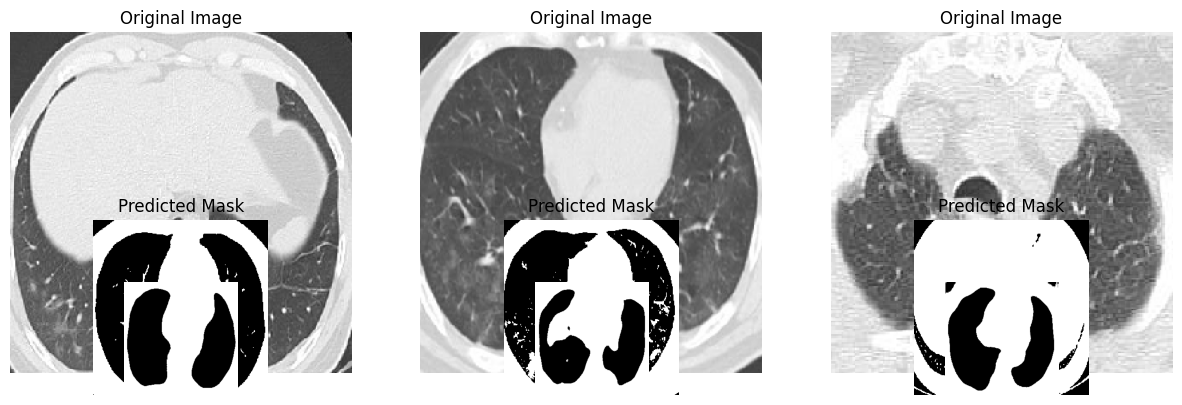

In [14]:
# Step 4: Visualize a Random Segmented Image
def visualize_segmentation(model, data_gen):
    # Get a random batch from the validation generator
    images, masks = data_gen[np.random.randint(0, len(data_gen))]
    
    # Predict the segmentation mask
    pred_masks = model.predict(images)
    
    # Convert predictions to class indices
    pred_masks = np.argmax(pred_masks, axis=-1)
    
    # Plot the original image, ground truth mask, and predicted mask
    plt.figure(figsize=(15, 5))
    for i in range(3):  # Visualize 3 samples
        plt.subplot(1, 3, i + 1)
        plt.imshow(images[i])
        plt.title("Original Image")
        plt.axis('off')
        
        plt.subplot(2, 3, i + 4)
        plt.imshow(np.argmax(masks[i], axis=-1), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')
        
        plt.subplot(3, 3, i + 7)
        plt.imshow(pred_masks[i], cmap='gray')
        plt.title("")
        plt.axis('off')
    plt.show()

# Visualize a random segmented image
visualize_segmentation(unet_model, val_gen)

In [15]:
# Step 5: Plot Training History
def plot_history(history, title):
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()


In [ ]:
# Compute ROC curve for each class
plt.figure()
for i in range(num_classes):
fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.show()